https://www.depends-on-the-definition.com/guide-to-word-vectors-with-gensim-and-keras/

https://adventuresinmachinelearning.com/word2vec-keras-tutorial/

Note: needs to run on GPU not TPU
Also note: link above has additional suggestions on improving accuracy

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pip install regex

     |████████████████████████████████| 655kB 2.8MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609236 sha256=e7f6734badb22cf832b6bdfa3f9e7bf8d3f93f967d1101a01694b5293c5ad719
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex


In [0]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import regex

In [0]:
df_pages_all = pd.read_pickle("/content/gdrive/My Drive/df_pages_all_backup.pkl")
#Filter out nulls
df = df_pages_all[df_pages_all.initial_message_text.notnull() == True]

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

# docs = train.initial_message_text.to_list()
# labels = train.section_number.to_list()

# docs_test = test.initial_message_text.to_list()
# labels_test = test.section_number.to_list()

In [6]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
#import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


# list_sentences_train = list(train_df["comment_text"].fillna("NAN_WORD").values)
# list_sentences_test = list(test_df["comment_text"].fillna("NAN_WORD").values)

list_sentences_train = list(train["initial_message_text"].fillna("NAN_WORD").values)
list_sentences_test = list(test["initial_message_text"].fillna("NAN_WORD").values)

comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

print("The vocabulary contains {} unique tokens".format(len(vocab)))

Processing text dataset


100%|██████████| 40558/40558 [00:03<00:00, 11624.20it/s]

The vocabulary contains 78292 unique tokens


In [0]:
from gensim.models import Word2Vec
model = Word2Vec(comments, size=100, window=5, min_count=5, workers=16, sg=0, negative=5)

In [8]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 18368


In [9]:
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])
#model.wv.most_similar_cosmul(positive=['api', 'ssl', 'neve'], negative=['plugin']),
#model.wv.most_similar_cosmul(positive=['flames', 'dhiadw'], negative=['nevermore'])
#model.wv.most_similar(positive=['mic', 'preamp'], negative=['mouse'])
model.wv.most_similar(positive=['insane'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sad', 0.6724885702133179),
 ('incredible', 0.6609996557235718),
 ('awkward', 0.6160253882408142),
 ('useless', 0.6133270859718323),
 ('absolute', 0.605295717716217),
 ('ridiculous', 0.6020516157150269),
 ('driving', 0.58767169713974),
 ('nuts', 0.5825567841529846),
 ('ugly', 0.5712347030639648),
 ('beside', 0.5693211555480957)]

In [10]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
#y = train_df[list_classes].values
y = train.section_number.values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (32446, 200)
Shape of label tensor: (32446,)
Shape of test_data tensor: (8112, 200)


In [0]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass        

In [0]:
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(7, activation='sigmoid')(x) 

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])



In [14]:
from keras.utils import np_utils
y_categorical = np_utils.to_categorical(y)

hist = model.fit([data], y_categorical, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Train on 29201 samples, validate on 3245 samples
Epoch 1/10
29201/29201 [==============================] - 13s 444us/step - loss: 0.5883 - val_loss: 0.3559
Epoch 2/10
29201/29201 [==============================] - 9s 318us/step - loss: 0.3294 - val_loss: 0.2723
Epoch 3/10
29201/29201 [==============================] - 10s 326us/step - loss: 0.2863 - val_loss: 0.2583
Epoch 4/10
29201/29201 [==============================] - 9s 324us/step - loss: 0.2714 - val_loss: 0.2520
Epoch 5/10
29201/29201 [==============================] - 9s 324us/step - loss: 0.2618 - val_loss: 0.2464
Epoch 6/10
29201/29201 [==============================] - 9s 320us/step - loss: 0.2553 - val_loss: 0.2406
Epoch 7/10
29201/29201 [==============================] - 9s 318us/step - loss: 0.2499 - val_loss: 0.2423
Epoch 8/10
29201/29201 [==============================] - 9s 319us/step - loss: 0.2448 - val_loss: 0.2364
Epoch 9/10
29201/29201 [==============================] - 9s 320us/step - loss: 0.2419 - val_loss: 0.

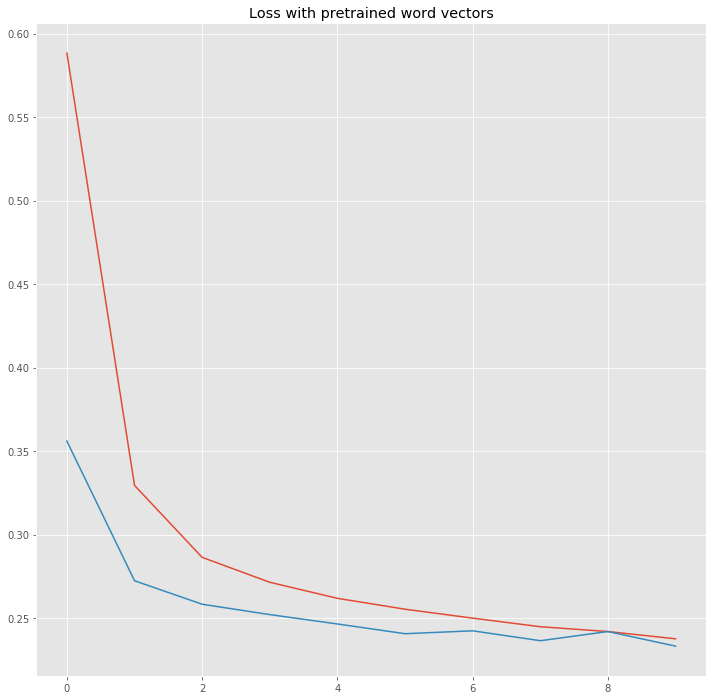

In [15]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors");
plt.show();

In [16]:
#word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_test):]]

# pad
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
#y = train_df[list_classes].values
y = train.section_number.values
print('Shape of data tensor:', data.shape)



Shape of data tensor: (32446, 200)


In [0]:
#predict(model, [test_data])
predictions = model.predict([test_data])